In [7]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from functools import reduce
import numpy.ma as ma
import pandas as pd
import scipy.interpolate
import numpy as np
import xarray as xr
import sys, time, os, dask, h5py
import random, warnings, pickle
import seaborn as sns
from matplotlib import cm, colors
from scipy.interpolate import interp1d
from xhistogram.xarray import histogram

In [2]:
sys.path.append(os.path.abspath("/groups/sylvia/UTLS-profiles/traj/"))
sys.path.append(os.path.abspath("/groups/sylvia/UTLS-profiles/utilities/"))
from flighttrack import *
from plotting_utilities import *
from thermodynamic_functions import *
from icetraj import *
farbe = sim_colors()

In [3]:
# Constants needed for mixing ratio conversion
mw_dryair = 28.97*1000    # kg air (mol air)-1
mw_watvap = 18.02*1000    # kg wv (mol wv)-1
conv = mw_dryair / mw_watvap

# PDFs of pressure along the synthetic trajs versus StratoClim flight

In [14]:
bd = '/groups/sylvia/UTLS-profiles/output/hold/'
syntraj = xr.open_dataset( bd + 'ICON_synthetic_trajs_1M0O_E.nc' )
p_syntraj = syntraj.plev.values.flatten()/100  # All values in hPa

bd2 = '/groups/sylvia/UTLS-profiles/obs/'
stratoclim = xr.open_dataset( bd2 + 'stratoclim2017.geophysika.0808_1.filtered_per_sec.nc' )
p_sc = stratoclim['BEST:PRESS'].values   # All values in hPa
print( np.nanmin(p_syntraj), np.nanmedian(p_syntraj), np.nanmean(p_syntraj), np.nanmax(p_syntraj) )
print( np.nanmin(p_sc), np.nanmedian(p_sc), np.nanmean(p_sc), np.nanmax(p_sc) )

64.30000305175781 144.12999725341797 269.29889015132034 862.5700073242188
64.3 144.13 269.2989 862.57


[0.00467436 0.01138951 0.00585996 0.00544209 0.00975688 0.01002899
 0.0019436  0.00170065 0.01001927 0.00132165 0.00127306 0.00180755
 0.00421762 0.00042759 0.00041787 0.00040816 0.00046646 0.00100096
 0.00036928 0.00034985 0.00035957 0.00032069 0.00028182 0.00030126
 0.00255584 0.00028182 0.00030126 0.00031098 0.00033041 0.00032069
 0.00428564 0.00033041 0.0002721  0.00034985 0.00883367 0.00033041
 0.00034985 0.00030126 0.00035957 0.00035957 0.00034985 0.00034985
 0.00040816 0.00038872 0.00033041 0.00030126 0.00029154 0.00030126
 0.00025267 0.00028182 0.00026239 0.0002721  0.0002721  0.00026239
 0.00029154 0.00028182 0.00026239 0.0002721  0.00078716 0.00099124
 0.00032069 0.00031098 0.00039844 0.00031098 0.00028182 0.00073857
 0.00083575 0.00040816 0.00030126 0.00137996 0.0042079  0.00044703
 0.00387749 0.00250725 0.00036928 0.00038872 0.00031098 0.00034013
 0.00028182 0.00023323 0.00017492 0.00013605 0.00014577 0.00022351
 0.0002138  0.00026239 0.00020408 0.00020408 0.0002138  0.0001

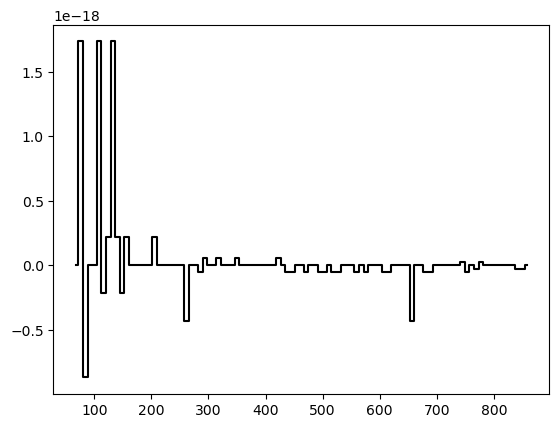

In [32]:
bins = np.linspace(64,862,100)
h1, _ = np.histogram( p_syntraj, density=True, bins=bins )
h2, _ = np.histogram( p_sc, density=True, bins=bins )
print(h1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
plt.step( bin_centers, h1-h2, where='mid', color='k' )
#plt.hist( p_sc, bins=np.linspace(64,862,50), alpha=0.5, density=True, edgecolor='k' )
plt.show()

# Computation of the histogram of vertical velocities from the simulations

In [5]:
# Load the observational w values and evaluate their histogram.
high_w = 3
low_w = 0.001
nbin = 70

In [6]:
# Load the vertical velocities between 200 and 70 hPa along the synthetic flight tracks
bd = '/xdisk/sylvia/UTLS_flight_output/'
sim_list = ['1M0O','1M1O','1M3O','2M0O','2M1O','2M3O']

def hist_pct_da(w_da, edges, wgts=None):
    if wgts is None:
        wgts = dask.array.ones_like(w_da)
    H_da, _ = dask.array.histogram(w_da, bins=edges, weights=wgts)
    total_w = wgts[dask.array.isfinite(w_da)].sum()
    H = H_da.compute()
    total_w = total_w.compute()
    return (H / total_w) * 100, edges

hup_by_sim = {}
hdown_by_sim = {}
bin_edges = np.logspace(np.log(low_w), np.log(high_w), nbin)
for sl in sim_list:
    print( sl )
    ds = xr.open_dataset(f"{bd}{sl}/ICON_3D_flight_{sl}.nc", chunks={"lat": 128, "lon": 128, "plev": 25, "time": 1})
    plev = ds['plev']
    w = ds['w']
    # Filter for UTLS pressures from 70 hPa down to 200 hPa 
    pmin, pmax = 7000.0, 20000.0
    # First updrafts
    mask = (plev >= pmin) & (plev <= pmax) & (w > 0)
    w_sel = ds['w'].where(mask, drop=True)   # (25,12,441,401)
    Hpct, edges = hist_pct_da(w_sel.data, bin_edges)
    hup_by_sim[sl] = (edges, Hpct)
    # Then downdrafts. Remember to take the absolute value (or multiply by -1).
    mask = (plev >= pmin) & (plev <= pmax) & (w < 0)
    w_sel = ds['w'].where(mask, drop=True) * -1  # (25,12,441,401)
    Hpct, edges = hist_pct_da(w_sel.data, bin_edges)
    hdown_by_sim[sl] = (edges, Hpct)

1M0O
1M1O
1M3O
2M0O
2M1O
2M3O


In [8]:
# Save the hup_by_sim and hdown_by_sim dictionaires from the code block above 
bd = '/groups/sylvia/UTLS-profiles/output/'
with open( bd + "hup_by_sim.pkl", "wb" ) as f:
    pickle.dump( hup_by_sim, f )
with open( bd + "hdown_by_sim.pkl", "wb" ) as f:
    pickle.dump( hdown_by_sim, f )

# Computation of the small domain-averaged qv and T profiles

In [ ]:
bd = '/xdisk/sylvia/UTLS_flight_output/'
sim_list = ['1M0O', '1M1O', '1M3O', '2M0O', '2M1O', '2M3O' ]
plev = xr.open_dataset( bd + '1M0O/ICON_3D_flight_1M0O.nc' )['plev']
mean_profiles = np.zeros( (2, len(sim_list), len(plev)) )
for i, sl in enumerate(sim_list):
    ds = xr.open_dataset( bd + sl + '/ICON_3D_flight_' + sl + '.nc' )
    t = ds['temp'].mean( dim=['time', 'lat', 'lon'] )
    q = ds['qv'].mean( dim=['time', 'lat', 'lon'] )
    mean_profiles[0, i] = t
    mean_profiles[1, i] = q

In [15]:
# Convert mean_profiles to a netcdf file
variables = ['mean_T', 'mean_qv']
da = xr.DataArray( mean_profiles, dims=["variable", "simulation", "pressure"], 
                  coords={"variable": variables, "simulation": sim_list, "pressure": plev.values},
                  name="mean_values" )
ds = da.to_dataset( dim="variable" )
ds.to_netcdf( '/groups/sylvia/UTLS-profiles/output/mean-T-qv-profiles.nc' )

# Percentages of temperature bias and stdev values

In [31]:
basedir = '/groups/sylvia/UTLS-profiles/output/'
syn_traj = xr.open_dataset(basedir + 'ICON_synthetic_trajs_1M0O_E.nc')
T = syn_traj.temp.values
P = syn_traj.pressure.values/100
t = syn_traj.time.values # DataArray of length 12770

# Read in-situ data
daten = xr.open_dataset('/groups/sylvia/UTLS-profiles/obs/stratoclim2017.geophysika.0808_1.filtered_per_sec.nc')
T_Stratoclim = daten['BEST:TEMP']
P_Stratoclim = daten['BEST:PRESS']
t_Stratoclim = daten['time']

In [51]:
Tm = np.nanmean( T, axis=1 )
Tstd = np.nanstd( T, axis=1 )
Tbias = Tm - T_Stratoclim

/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [52]:
# Identify the best trajectory
Tdiff = T - T_Stratoclim.values[:, np.newaxis]
jmin = np.argmin( np.abs(Tdiff), axis=1 )
most_common_jmin = np.bincount(jmin).argmax()
best_traj = Tdiff[:, most_common_jmin]

In [53]:
# What percent of temperature biases fall between +/-2K? Or some other threshold.
mask1 = np.abs(Tbias) <= 1
mask2 = np.abs(Tbias) <= 2
mask3 = np.abs(Tbias) <= 3
mask5 = np.abs(Tbias) >= 5
percent_within_1k = np.count_nonzero( mask1 ) / Tbias.size * 100
percent_within_2k = np.count_nonzero( mask2 ) / Tbias.size * 100
percent_within_3k = np.count_nonzero( mask3 ) / Tbias.size * 100
percent_outside_5k = np.count_nonzero( mask5 ) / Tbias.size * 100
print( percent_within_1k )
print( percent_within_2k )
print( percent_within_3k )
print( percent_outside_5k )

39.185591229444015
64.9177760375881
81.46436961628818
10.156617071260769


In [54]:
# What percent of temperature biases fall between +/-2K for the best trajectory? Or some other threshold.
mask1 = np.abs(best_traj) <= 1
mask2 = np.abs(best_traj) <= 2
mask3 = np.abs(best_traj) <= 3
mask5 = np.abs(best_traj) >= 5
percent_within_1k = np.count_nonzero( mask1 ) / best_traj.size * 100
percent_within_2k = np.count_nonzero( mask2 ) / best_traj.size * 100
percent_within_3k = np.count_nonzero( mask3 ) / best_traj.size * 100
percent_outside_5k = np.count_nonzero( mask5 ) / best_traj.size * 100
print( percent_within_1k )
print( percent_within_2k )
print( percent_within_3k )
print( percent_outside_5k )

38.112764291307755
64.65935787000782
81.49569303054032
10.24275646045419


In [11]:
# What percentage of stdev in temperature falls in certain ranges?
mask1 = np.abs( Tstd ) <= 0.25
mask2 = np.abs( Tstd ) <= 0.5
mask3 = np.abs( Tstd ) <= 1
percent1 = np.count_nonzero( mask1 ) / Tbias.size * 100
percent2 = np.count_nonzero( mask2 ) / Tbias.size * 100
percent3 = np.count_nonzero( mask3 ) / Tbias.size * 100

print( percent1 )
print( percent2 )
print( percent3 )

67.78386844166015
96.57791699295223
99.78073610023492


In [16]:
# Calculate upper bound of the temperature bias from the profiles.

tag = '_E'  # E = 'extract', default 20 synthetic trajectories
#tag = '_E2' # Second (or third) set of 20 synthetic trajectories to test reproducibility
#tag = '_C' # C = 'collocate', minimize the Euclidean distance between sim and obs values
#tag = '_full' # Statistics over the full Flight 7 track

bd = '/groups/sylvia/UTLS-profiles/output/'
stats = []
sim_list = ['1M0O','1M1O','1M3O','2M0O','2M1O','2M3O']
for s in sim_list: 
    ds = xr.open_dataset( bd + 'ICON_synthetic_trajs_stats_' + s + tag + '.nc' )
    stats.append( ds )
plev = ds.pressure

In [15]:
# Read in-situ data
time0 = datetime(2017, 8, 8, 6, 20)
timef = datetime(2017, 8, 8, 6, 48)
p1, qv_flash, qv_fish, p2, qi_obs, p3, temp, theta, p4, rhice_flash, rhice_fish = \
    read_flighttrack( time0, timef )

# Bin the in-situ data by pressure levels from the simulation
bins_sims, temp_SC_stats, theta_SC_stats, qv_flash_SC_stats, qv_fish_SC_stats, qi_SC_stats, RHi_SC_stats = \
    bin_flighttrack( p1, qv_flash, qv_fish, p2, qi_obs, p3, temp, theta, p4, rhice_flash, rhice_fish )

/groups/sylvia/UTLS-profiles/traj/flighttrack.py:94: RuntimeWarning: Mean of empty slice
  stats[0, i] = np.nanmean(values)
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1120: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [52]:
# Print the maximum temperature bias below 110 hPa
jj = np.argwhere( plev.values <= 11000 )[-1].item()
kk = np.argwhere( plev.values <= 20000 )[-1].item()

# Specify whether to compare means (l = 0) or medians (l = 1)
k = 'mean'; l = 0
tbiasmax_above = []
tbiasmax_below = []
thetabiasmax_above = []
thetabiasmax_below = []

for i, sl in zip(np.arange(len(sim_list)), sim_list):
    tm = np.nanmean( stats[i]['temp_'+k], axis=1 )
    thetam = np.nanmean( stats[i]['theta_'+k], axis=1 )
    tdiff = tm-temp_SC_stats[l]
    thetadiff = thetam-theta_SC_stats[l]

    idx_t_above = np.nanargmax(np.abs(tdiff[:jj]))
    idx_theta_above = np.nanargmax(np.abs(thetadiff[:jj]))
    t_above = tdiff[:jj]
    theta_above = thetadiff[:jj]

    idx_t_below = np.nanargmax(np.abs(tdiff[jj:kk]))
    idx_theta_below = np.nanargmax(np.abs(thetadiff[jj:kk]))
    t_below = tdiff[jj:kk]
    theta_below = thetadiff[jj:kk]
    
    # Maximum temperature + theta differences above 100 hPa
    print( 'Above/Below 110 hPa -- ' + sl )
    print( str(t_above[idx_t_above]) + ' // ' + str(t_below[idx_t_below]) ) 
    print( str(theta_above[idx_theta_above])+ ' // ' + str(theta_below[idx_theta_below]) )
    tbiasmax_above.append( t_above[idx_t_above] )
    thetabiasmax_above.append( theta_above[idx_t_above] )
    print( '~~~~~~' )
    
    # Maximum temperature + theta differences below 100 hPa
    print( 'Ratio above/below 110 hPa -- ' + sl )
    print( np.abs(t_above[idx_t_above])/np.abs(t_below[idx_t_below]) ) 
    print( np.abs(theta_above[idx_theta_above])/np.abs(theta_below[idx_theta_below]) )
    tbiasmax_below.append( t_below[idx_t_below] )
    thetabiasmax_below.append( theta_below[idx_theta_below] )
    print( '~~~~~~~~~~~~~~~~~~~~~~~~~~~~' )

Above/Below 110 hPa -- 1M0O
3.5073841568186026 // -1.3200833149872722
10.024833094995756 // -2.4983799356680834
~~~~~~
Ratio above/below 110 hPa -- 1M0O
2.6569415104321803
4.012533462935872
~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Above/Below 110 hPa -- 1M1O
3.3882919511111425 // -1.195972565896625
9.77542237822638 // -2.2741744822349688
~~~~~~
Ratio above/below 110 hPa -- 1M1O
2.8330850119215967
4.298448713846917
~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Above/Below 110 hPa -- 1M3O
2.9524720860734703 // -1.307046445488396
8.862699800996609 // -2.4748288954982627
~~~~~~
Ratio above/below 110 hPa -- 1M3O
2.258888424558041
3.581136383657854
~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Above/Below 110 hPa -- 2M0O
2.7133265029328015 // -1.044399351992837
8.361865418519642 // -1.5428472298607971
~~~~~~
Ratio above/below 110 hPa -- 2M0O
2.5979779648038415
5.419762408540014
~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Above/Below 110 hPa -- 2M1O
3.0116355039700977 // -1.2312568147303296
8.986603715417118 // -1.8477433108899959
~~~~~~
Ratio above/be

/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  


In [42]:
# What is the average maximum bias above and below 100 hPa in T?
print( np.nanmean(tbiasmax_above) )
print( np.nanmean(tbiasmax_below) )
print( '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~' )

# What is the average maximum bias above and below 100 hPa in theta?
print( np.nanmean(thetabiasmax_above) )
print( np.nanmean(thetabiasmax_below) )
print( '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~' )

# How much do the models differ in their max bias above and below 100 hPa in T?
print( np.nanmax(np.abs(tbiasmax_above)) - np.nanmin(np.abs(tbiasmax_above)) )
print( np.nanmax(np.abs(tbiasmax_below)) - np.nanmin(np.abs(tbiasmax_below)) )
print( '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~' )

3.08204971710506
1.6478847860459684
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
9.134069783951057
3.241068270466419
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.7940576538858011
0.25127893476340546
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# Understanding consistency of T time series and profiles

In [65]:
# For which temperatures do biases >+/-5 K occur?
basedir = '/groups/sylvia/UTLS-profiles/output/'
syn_traj = xr.open_dataset(basedir + 'ICON_synthetic_trajs_1M0O_E.nc')
T = syn_traj.temp.values
P = syn_traj.pressure.values/100
t = syn_traj.time.values # DataArray of length 12770

# Read in-situ data
daten = xr.open_dataset('/groups/sylvia/UTLS-profiles/obs/stratoclim2017.geophysika.0808_1.filtered_per_sec.nc')
T_Stratoclim = daten['BEST:TEMP']
P_Stratoclim = daten['BEST:PRESS']
t_Stratoclim = daten['time']

Tm = np.nanmean( T, axis=1 )
Tstd = np.nanstd( T, axis=1 )
Tbias = Tm - T_Stratoclim

large_bias_indx = np.argwhere( np.abs(Tbias.values) > 5 )[:,0]
T_at_large_bias_indx = T[large_bias_indx]

(1297, 20)


/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


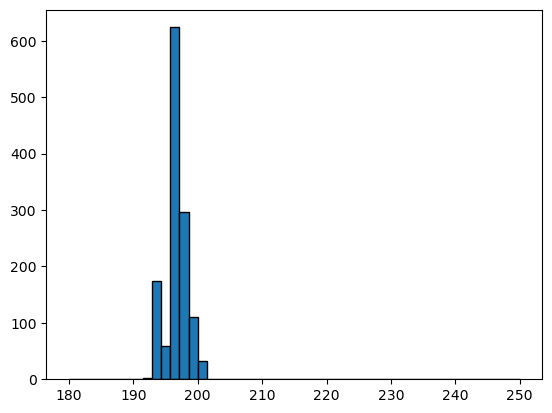

In [73]:
plt.hist( T_at_large_bias_indx[:,1], bins=np.linspace(180,250,50), edgecolor='k' )
plt.show()

In [68]:
# What about if we filter only for the period of ascent / descent?
basedir = '/groups/sylvia/UTLS-profiles/output/'
syn_traj = xr.open_dataset(basedir + 'ICON_synthetic_trajs_1M0O_E.nc')

# Time range from Lee et al. 2019 (6:20-6:48 UTC)    
time0 = datetime(2017, 8, 8, 6, 20)
timef = datetime(2017, 8, 8, 6, 48)
T_sub = syn_traj.temp.sel(time=slice(time0,timef))

# Read in-situ data
daten = xr.open_dataset('/groups/sylvia/UTLS-profiles/obs/stratoclim2017.geophysika.0808_1.filtered_per_sec.nc')
T_Stratoclim_sub = daten['BEST:TEMP'].sel(time=slice(time0,timef))

Tm_sub = np.nanmean( T_sub, axis=1 )
Tbias_sub = Tm_sub - T_Stratoclim_sub

large_bias_indx_sub = np.argwhere( np.abs(Tbias_sub.values) > 5 )[:,0]
T_at_large_bias_indx_sub = T[large_bias_indx_sub]

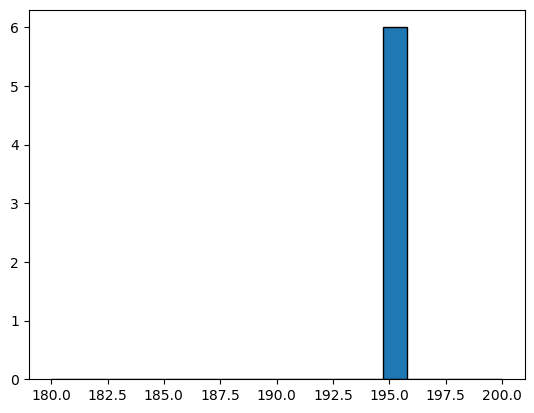

In [72]:
plt.hist( T_at_large_bias_indx_sub[:,1], bins=np.linspace(180,200,20), edgecolor='k' )
plt.show()

50.28382213812678


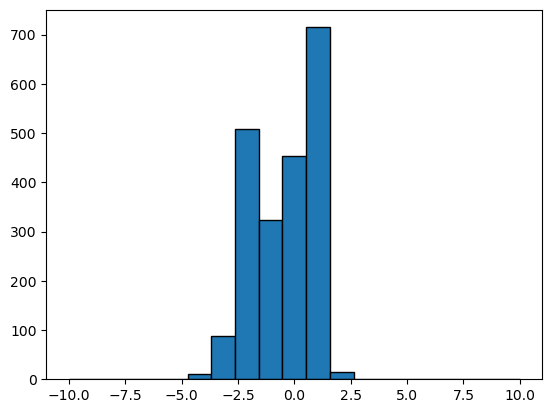

In [85]:
# Now go in the opposite direction. Are all instances of 185-200 K necessarily biased?
#j_cold = np.argwhere( (Tm > 185) & (Tm < 200) )[:,0]
j_cold = np.argwhere( (Tm > 200) & (Tm < 220) )[:,0]
Tbias_cold = Tbias[j_cold]
percent_positive = np.count_nonzero(Tbias_cold > 0) / len(Tbias_cold) * 100
print(percent_positive)

plt.hist( Tbias_cold, bins=np.linspace(-10,10,20), edgecolor='k' )
plt.show()

# Computation of the T differences between in-situ obs and sondes or MLS

In [19]:
# Sonde data
bd = '/groups/sylvia/UTLS-profiles/obs/'
#sonde_id = [ '42182', '42867', '42089' ]
sonde_id = [ '42379', '42492', '42701', '42867', '42809', '42361' ]
sonde_list_temperature = []
sonde_list_pressure = []
for i in sonde_id:
    fi = bd + 'Sonde-' + i + '-20170808T00.txt'
    df_raw = pd.read_csv( fi, sep='\s+', header=None, engine='python' )
    
    # Use the first row of text as column headers
    new_columns = [f"{var} [{unit}]" for var, unit in zip(df_raw.iloc[0], df_raw.iloc[1])]
    df_raw.columns = new_columns
    df_clean = df_raw.drop(index=[0, 1]).reset_index(drop=True).astype(float)

    # Append the temperature, qv, and pressure to sonde_list_temperature
    sonde_list_temperature.append( df_clean['TEMP [C]'].values + 273 )
    p = df_clean['PRES [hPa]'].values
    sonde_list_pressure.append( p )

In [20]:
# Create mean sonde data also by interpolating to a set of reference pressures across all sites
interpolated_temperatures = []
ref_pressure = sonde_list_pressure[0]
for p, t in zip(sonde_list_pressure, sonde_list_temperature):
    sort_idx = np.argsort(p)[::-1]
    p_sorted = p[sort_idx]
    t_sorted = t[sort_idx]

    f_interp = interp1d( p_sorted, t_sorted, kind='linear', bounds_error=False, fill_value=np.nan )
    interp_t = f_interp( ref_pressure )
    interpolated_temperatures.append( interp_t )

In [21]:
mean_sonde_temperature = np.nanmean( interpolated_temperatures, axis=0 )
mean_sonde_pressure = ref_pressure

In [22]:
# Time range from Lee et al. 2019 (6:20-6:48 UTC)    
time0 = datetime(2017, 8, 8, 6, 20)
timef = datetime(2017, 8, 8, 6, 48)

# Read in-situ data
p1, qv_flash, qv_fish, p2, qi_obs, p3, temp, theta, p4, rhice_flash, rhice_fish = \
    read_flighttrack( time0, timef )

# Bin the in-situ data
_, temp_SC_sonde, _, _, _, _, _ = \
    bin_flighttrack_general( np.flip(ref_pressure)*100, p1, qv_flash, qv_fish, p2, qi_obs, p3, temp, theta, p4, rhice_flash, rhice_fish )
temp_SC_sonde = np.flip(temp_SC_sonde, axis=1)

/groups/sylvia/UTLS-profiles/traj/flighttrack.py:91: RuntimeWarning: Mean of empty slice
  stats[0, i] = np.nanmean(values)
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1120: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [31]:
j = np.argwhere( (ref_pressure <= 200) & (ref_pressure >= 70) )[:,0]
print(j)
print(ref_pressure[j])
temp_diff_sonde = mean_sonde_temperature[j] - temp_SC_sonde[0][j]
print( np.nanmin(temp_diff_sonde), np.nanmean(temp_diff_sonde), np.nanmedian(temp_diff_sonde), np.nanmax(temp_diff_sonde) )

[51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66]
[200.  180.  172.  150.  137.  105.  100.   97.8  97.   91.   87.9  87.
  83.   79.   77.   70. ]
-2.5283528645833258 0.32816209863847995 0.42133382161458144 1.7706602070346378


In [35]:
# MLS data
filename = 'MLS-Aura_L2GP-Temperature_v05-01-c01_2017d220.he5'
with h5py.File( bd + filename, 'r' ) as f:
    mls_temperature = f['HDFEOS/SWATHS/Temperature/Data Fields/Temperature'][:]  # (3495, 55)
    lat = f['HDFEOS/SWATHS/Temperature/Geolocation Fields/Latitude'][:] # (3495, )
    lon = f['HDFEOS/SWATHS/Temperature/Geolocation Fields/Longitude'][:] # (3495, )
    mls_pressure1 = f['HDFEOS/SWATHS/Temperature/Geolocation Fields/Pressure'][:] # (55, )

# Filter for temperature and qv data where lat and lon fall within the box
mask = ( (lon >= 80) & (lon <= 90) & (lat >= 19) & (lat <=30) )
mls_temperature_filtered = mls_temperature[mask, :]

In [46]:
# Interpolate the in-situ data to the MLS, reanalysis, and sonde levels
# Factor of 100 converts from hPa to Pa
_, temp_SC_mls, _, _, _, _, _ = \
    bin_flighttrack_general( np.flip(mls_pressure1)*100, p1, qv_flash, qv_fish, p2, qi_obs, p3, temp, theta, p4, rhice_flash, rhice_fish )

# Flip back to the same direction as mls_pressure1
temp_SC_mls = np.flip(temp_SC_mls, axis=1)

# Retain only the mean of the three statistics that are output
temp_SC_mls0 = temp_SC_mls[0] 

In [48]:
j = np.argwhere( (mls_pressure1 <= 200) & (mls_pressure1 >= 70) )[:,0]
for i in range(8):
    temp_diff_mls = mls_temperature_filtered[i,j] - temp_SC_mls0[j]
    print(temp_diff_mls)

[-1.75419617 -0.03347778 -1.79681396 -2.92388916 -1.75912476]
[-7.23680115 -2.61167908 -0.9967041  -0.11050415 -2.86831665]
[-5.13468933 -1.26356506  1.61929321  0.71968079  1.83973694]
[-8.25340271 -4.62701416 -2.19229126 -1.80351257 -4.36608887]
[-17.92469788  -7.92185974   2.33421326   6.25537109   0.90037537]
[-10.54574585   1.0247345    5.77058411   2.92375183  -4.05381775]
[-16.14868164  -6.3170929    1.66473389   4.71688843   0.39573669]
[-8.95016479 -4.3891449  -0.4675293   1.48460388 -0.54348755]


# Plot the standard deviation of temperature across trajectories in a relative sense

/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


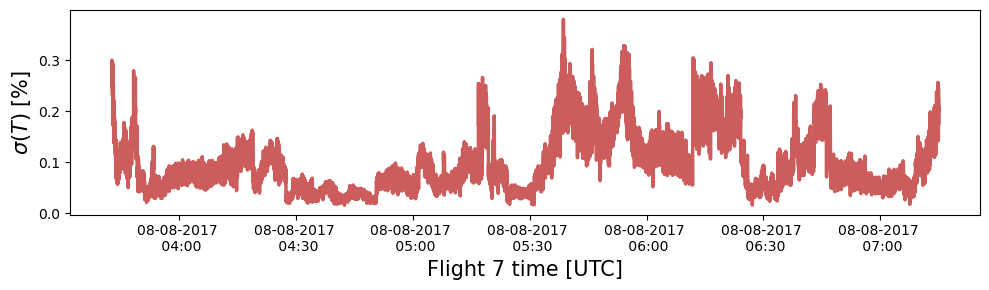

In [34]:
fs = 12
Tm = np.nanmean( T, axis=1 )
Tstd = np.nanstd( T, axis=1 )
Pm = np.nanmean( P, axis=1 )

plt.figure( figsize=(10,3) )
plt.plot(t, Tstd/T_Stratoclim * 100, color='indianred', linewidth=2.5)
plt.gca().set_ylabel(r'$\sigma(T)$ [%]', fontsize=fs+3)
plt.gca().set_xticklabels(['08-08-2017 \n 04:00', '08-08-2017 \n 04:30','08-08-2017 \n 05:00','08-08-2017 \n 05:30',
    '08-08-2017 \n 06:00','08-08-2017 \n 06:30','08-08-2017 \n 07:00'])
plt.gca().set_xlabel('Flight 7 time [UTC]', fontsize=fs+3)

plt.tight_layout()
plt.show()

# Correlation of temperature bias, observed temperature, and stdev 

In [5]:
mask = ~np.isnan(Tm) & ~np.isnan(T_Stratoclim)
r, p = scipy.stats.pearsonr( Tm[mask], Tbias[mask] )
print( 'Correlation of model bias with measured temperature: ' + str(r) )
print(f"r = {r:.6f}, p = {p:.3e}") 
print( 'Negative value implies that bias increases at colder temps.' )

Correlation of model bias with measured temperature: -0.5073969477641302
r = -0.507397, p = 0.000e+00
Negative value implies that bias increases at colder temps.


/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [8]:
# Calculate the temperature range over which the temperature bias is largest
tt = np.arange(185, 230, 10)
for i, t in enumerate(tt[:-1]):
    mask = (T_Stratoclim > t) & (T_Stratoclim <= tt[i+1])
    T_Stratoclim_masked = T_Stratoclim[mask]
    Tbias_masked = np.abs(Tbias[mask])
    r, p = scipy.stats.pearsonr( T_Stratoclim_masked, Tbias_masked )
    print('Temperature from ' + str(t) + ' to ' + str(tt[i+1]))
    print( np.nanmean(Tbias_masked) )
    print(f"r = {r:.6f}, p = {p:.3e}")

Temperature from 185 to 195
3.7694248827249566
r = -0.655578, p = 0.000e+00
Temperature from 195 to 205
1.379056623271589
r = -0.440871, p = 6.742e-103
Temperature from 205 to 215
1.0246015524764438
r = 0.399775, p = 5.413e-38
Temperature from 215 to 225
1.7133191354957544
r = -0.396959, p = 1.572e-17


In [9]:
# Calculate the correlation of temperature bias and rate of change in temperature
dt = (t_Stratoclim[1:].values - t_Stratoclim[:-1].values) / np.timedelta64(1, 's')
dTdt = (T_Stratoclim[1:].values - T_Stratoclim[:-1].values)/dt
Tbias_short = Tbias[:-1]
mask = ~np.isnan(dTdt) & ~np.isnan(Tbias_short)
r, p = scipy.stats.pearsonr( dTdt[mask], Tbias_short[mask] )
print( 'Correlation of model bias with temperature rate of change: ' + str(r) )
print(f"r = {r:.6f}, p = {p:.3e}") 

# Calculate the correlation of standard deviation across trajectories and rate of change in temperature
Tstd_short = Tstd[1:]
mask = ~np.isnan(dTdt) & ~np.isnan(Tstd_short)
r, p = scipy.stats.pearsonr( dTdt[mask], Tstd_short[mask] )
print( 'Correlation of stdev in model trajectories with temperature rate of change: ' + str(r) )
print(f"r = {r:.6f}, p = {p:.3e}") 

# Calculate the correlation of standard deviation across trajectories and observed temperature
mask = ~np.isnan(T_Stratoclim) & ~np.isnan(Tstd)
r, p = scipy.stats.pearsonr( T_Stratoclim[mask], Tstd[mask] )
print( 'Correlation of stdev in model trajectories with observed temperatures: ' + str(r) )
print(f"r = {r:.6f}, p = {p:.3e}") 

Correlation of model bias with temperature rate of change: 0.05746615852037414
r = 0.057466, p = 8.497e-11
Correlation of stdev in model trajectories with temperature rate of change: -0.015175012699622393
r = -0.015175, p = 8.674e-02
Correlation of stdev in model trajectories with observed temperatures: 0.1299572011972714
r = 0.129957, p = 4.095e-49


In [24]:
# The worst temperature biases occur from 08-08-2017 05:30-06:30
# Full flight track 
time0 = datetime(2017, 8, 8, 3, 20)
timef = datetime(2017, 8, 8, 7, 48)

p1, qv_flash, qv_fish, p2, qi_obs, p3, temp, theta, p4, rhice_flash, rhice_fish = \
    read_flighttrack( time0, timef )
print( np.nanmin(temp), np.nanmedian(temp), np.nanmean(temp), np.nanmax(temp) )

# Period with largest negative temperature bias
time0 = datetime(2017, 8, 8, 5, 30)
timef = datetime(2017, 8, 8, 6, 20)

p1, qv_flash, qv_fish, p2, qi_obs, p3, temp, theta, p4, rhice_flash, rhice_fish = \
    read_flighttrack( time0, timef )
print( np.nanmin(temp), np.nanmedian(temp), np.nanmean(temp), np.nanmax(temp) )

186.9 208.9 227.7904 299.7
186.9 190.4 191.83641 211.4


# Percentages of qv bias and stdev values

In [58]:
basedir = '/groups/sylvia/UTLS-profiles/output/'
syn_traj = xr.open_dataset(basedir + 'ICON_synthetic_trajs_1M0O_E.nc')
qv_sim = syn_traj.qv.values * conv * 10**6
qi_sim = syn_traj.qi.values * conv * 10**6
t = syn_traj.time.values # DataArray of length 12770

# Read in-situ data
daten = xr.open_dataset('/groups/sylvia/UTLS-profiles/obs/stratoclim2017.geophysika.0808_1.filtered_per_sec.nc')
qv_Stratoclim1 = daten['BEST:H2O_enh']
qv_Stratoclim2 = daten['BEST:H2O_gas']
qi_Stratoclim = daten['BEST:IWC']
t_Stratoclim = daten['time']

In [66]:
qvm = np.nanmean( qv_sim, axis=1 )
qvstd = np.nanstd( qv_sim, axis=1 )
qvbias = qvm - qv_Stratoclim2
qvrelbias = (qvm - qv_Stratoclim2)/qv_Stratoclim2 * 100

/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1671: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [64]:
# What percent of qv biases fall in certain ranges?
mask1 = np.abs(qvbias) <= 1
mask2 = np.abs(qvbias) <= 5
mask3 = np.abs(qvbias) <= 10
mask5 = np.abs(qvbias) <= 50
qvbias_size = np.count_nonzero( ~np.isnan(qvbias) )
percent_within_1k = np.count_nonzero( mask1 ) / qvbias_size * 100
percent_within_2k = np.count_nonzero( mask2 ) / qvbias_size * 100
percent_within_3k = np.count_nonzero( mask3 ) / qvbias_size * 100
percent_outside_5k = np.count_nonzero( mask5 ) / qvbias_size * 100
print( percent_within_1k )
print( percent_within_2k )
print( percent_within_3k )
print( percent_outside_5k )

43.23576525411388
87.18508810251929
91.78680646570555
98.76219600990244


In [68]:
# What percent of relative (percent) qv biases fall in certain ranges?
mask1 = np.abs(qvrelbias) <= 5
mask2 = np.abs(qvrelbias) <= 10
mask3 = np.abs(qvrelbias) <= 20
mask5 = np.abs(qvrelbias) <= 50
qvrelbias_size = np.count_nonzero( ~np.isnan(qvrelbias) )
percent_within_1k = np.count_nonzero( mask1 ) / qvrelbias_size * 100
percent_within_2k = np.count_nonzero( mask2 ) / qvrelbias_size * 100
percent_within_3k = np.count_nonzero( mask3 ) / qvrelbias_size * 100
percent_outside_5k = np.count_nonzero( mask5 ) / qvrelbias_size * 100
print( percent_within_1k )
print( percent_within_2k )
print( percent_within_3k )
print( percent_outside_5k )

12.21785350225717
24.37745740498034
57.73991553808068
98.50007281199942


# Correlation of qv bias with other variables (qv, T, stdev T, etc.)

In [24]:
basedir = '/groups/sylvia/UTLS-profiles/output/'
syn_traj = xr.open_dataset(basedir + 'ICON_synthetic_trajs_1M0O_E.nc')
qv_sim = syn_traj.qv.values * conv * 10**6
t = syn_traj.time.values # DataArray of length 12770

# Read in-situ data
daten = xr.open_dataset('/groups/sylvia/UTLS-profiles/obs/stratoclim2017.geophysika.0808_1.filtered_per_sec.nc')
qv_Stratoclim1 = daten['BEST:H2O_enh']
qv_Stratoclim2 = daten['BEST:H2O_gas']
T_Stratoclim = daten['BEST:TEMP']
t_Stratoclim = daten['time']

In [25]:
qvm = np.nanmean( qv_sim, axis=1 )
qvbias = (qvm - qv_Stratoclim2)/qv_Stratoclim2 * 100
mask = ~np.isnan(qvm) & ~np.isnan(qv_Stratoclim2)
r, p = scipy.stats.pearsonr( qvm[mask], qvbias[mask] )
print( 'Correlation of model bias with measured qv: ' + str(r) )
print(f"r = {r:.6f}, p = {p:.3e}") 
print( 'Positive value implies that bias increases at larger specific humidities' )

Correlation of model bias with measured qv: 0.3450186159323936
r = 0.345019, p = 3.244e-191
Positive value implies that bias increases at larger specific humidities


/home/u18/sylvia/.conda/envs/ncplot/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [26]:
# How strongly do the qv biases correlate with temperature?
mask = ~np.isnan(qvbias) & ~np.isnan(T_Stratoclim)
r, p = scipy.stats.pearsonr( T_Stratoclim[mask], qvbias[mask] )
print( 'Correlation of model bias with measured temperature: ' + str(r) )
print(f"r = {r:.6f}, p = {p:.3e}") 

Correlation of model bias with measured temperature: 0.2776165354938335
r = 0.277617, p = 9.543e-122


In [29]:
# How strongly do the qv biases correlate with dT/dt?
dt = (t_Stratoclim[1:].values - t_Stratoclim[:-1].values) / np.timedelta64(1, 's')
dTdt = (T_Stratoclim[1:].values - T_Stratoclim[:-1].values)/dt
qvbias_short = qvbias[:-1]
mask = ~np.isnan(qvbias_short) & ~np.isnan(dTdt)
r, p = scipy.stats.pearsonr( dTdt[mask], qvbias_short[mask] )
print( 'Correlation of model bias with aircraft descent/ascent: ' + str(r) )
print(f"r = {r:.6f}, p = {p:.3e}") 

Correlation of model bias with measured temperature: 0.1422492010312933
r = 0.142249, p = 2.258e-32


In [12]:
# How different is the correlation of qv bias with qv observation across the trajectories?
for i in range(20):
    qvbias_sub = (qv_sim[:,i] - qv_Stratoclim2)/qv_Stratoclim2 * 100
    mask = ~np.isnan(qv_sim[:,i]) & ~np.isnan(qv_Stratoclim2)
    r, p = scipy.stats.pearsonr( qv_sim[mask,i], qvbias_sub[mask] )
    print( 'Correlation of model bias with measured qv: ' + str(r) )

Correlation of model bias with measured qv: 0.3464590735293315
Correlation of model bias with measured qv: 0.34655716914606527
Correlation of model bias with measured qv: 0.34198845943272105
Correlation of model bias with measured qv: 0.33817302304038876
Correlation of model bias with measured qv: 0.3433961901923687
Correlation of model bias with measured qv: 0.34138337173375954
Correlation of model bias with measured qv: 0.34065250106237244
Correlation of model bias with measured qv: 0.34602404509453477
Correlation of model bias with measured qv: 0.3476133048161075
Correlation of model bias with measured qv: 0.3471817678785103
Correlation of model bias with measured qv: 0.3479158922547667
Correlation of model bias with measured qv: 0.3467483169688545
Correlation of model bias with measured qv: 0.3420252634422529
Correlation of model bias with measured qv: 0.34071074465186146
Correlation of model bias with measured qv: 0.3486561271774611
Correlation of model bias with measured qv: 0.34

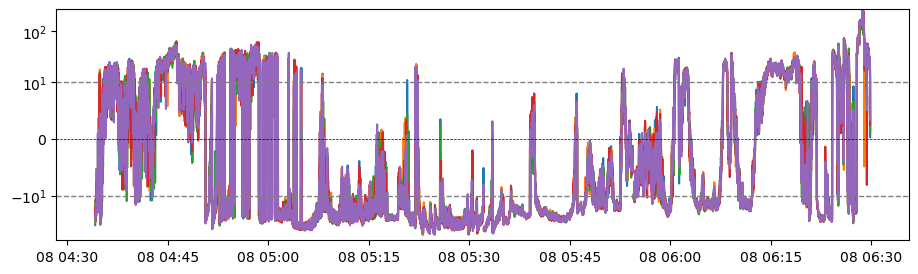

In [23]:
# Can we plot the bias of the first five trjaectories just to understand how different they are?
plt.figure( figsize=(11,3) )
for i in range(5):
    plt.plot( t_Stratoclim, (qv_sim[:,i] - qv_Stratoclim2)/qv_Stratoclim2 * 100 )
plt.gca().axhline( y=0, color='k', lw=0.5, linestyle='--' )
plt.gca().set_yscale( 'symlog', linthresh=1e1 )
plt.gca().axhline( y=10, color='gray', ls='--', lw=1 )
plt.gca().axhline( y=-10, color='gray', ls='--', lw=1 )

# Particular qv values at upper levels in ICON and obs

In [5]:
# Which set of trajectory statistics do you want to open?
tag = '_E'  # E = 'extract', default 20 synthetic trajectories
#tag = '_E2' # Second (or third) set of 20 synthetic trajectories to test reproducibility
#tag = '_C' # C = 'collocate', minimize the Euclidean distance between sim and obs values
#tag = '_full' # Statistics over the full Flight 7 track

bd = '/groups/sylvia/UTLS-profiles/output/'
stats = []
sim_list = ['1M0O','1M1O','1M3O','2M0O','2M1O','2M3O']
for s in sim_list: 
    ds = xr.open_dataset( bd + 'ICON_synthetic_trajs_stats_' + s + tag + '.nc' )
    stats.append( ds )

plev = ds.pressure

In [40]:
# Specify whether to compare means (l = 0) or medians (l = 1)
k = 'mean'; l = 0

for i, sl in zip(np.arange(len(sim_list)), sim_list):
    qvm = np.nanmean( stats[i]['qv_'+k], axis=1 )
plev_hpa = plev.values/100
j = np.argwhere( (plev_hpa >= 68) & (plev_hpa <= 110) )[:,0]
print( qvm[j] )
print( plev_hpa[j] )

qvm_sub = qvm[j]
plev_hpa_sub = plev_hpa[j]

print( 'What are the locations of the min-max qv in the 110-70 hPa range?')
print( plev_hpa_sub[np.argmin(qvm_sub)], plev_hpa_sub[np.argmax(qvm_sub)] )
print( 'What are the min-max qv values in the 110-70 hPa range?')
print( np.nanmin(qvm_sub), np.nanmax(qvm_sub) )

[5.23327143 4.37285363 4.12539866 5.01171274]
[ 75.4243  84.6072  94.4617 104.8516]
What are the locations of the min-max qv in the 110-70 hPa range?
94.46170000000001 75.4243
What are the min-max qv values in the 110-70 hPa range?
4.125398659618947 5.233271434065509


In [32]:
# Time range from Lee et al. 2019 (6:20-6:48 UTC)    
time0 = datetime(2017, 8, 8, 6, 20)
timef = datetime(2017, 8, 8, 6, 48)

# Full Flight 7 statistics
#time0 = datetime(2017, 8, 8, 4, 0)
#timef = datetime(2017, 8, 8, 7, 15)

# Suppress warnings about levels where there are no data
warnings.filterwarnings("ignore", message="All-NaN slice encountered")
warnings.filterwarnings("ignore", message="Mean of empty slice")
warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice")

# Read in-situ data
p1, qv_flash, qv_fish, p2, qi_obs, p3, temp, theta, p4, rhice_flash, rhice_fish = \
    read_flighttrack( time0, timef )

# Extract qv_flash values between 110 and 70 hPa
mask = np.argwhere( (p1 > 70) & (p1 < 110) )
qv_flash_sub = qv_flash.values[mask]
p1_sub = p1[mask]
print( 'What are the locations of the min-max qv in the 110-70 hPa range?')
print( p1_sub[np.argmin(qv_flash_sub)][0], p1_sub[np.argmax(qv_flash_sub)][0] )
print( 'What are the min-max qv values in the 110-70 hPa range?')
print( np.nanmin(qv_flash_sub), np.nanmax(qv_flash_sub) )

What are the locations of the min-max qv in the 110-70 hPa range?
86.74 78.26
What are the min-max qv values in the 110-70 hPa range?
3.33 5.77


(120.0, 70.0)

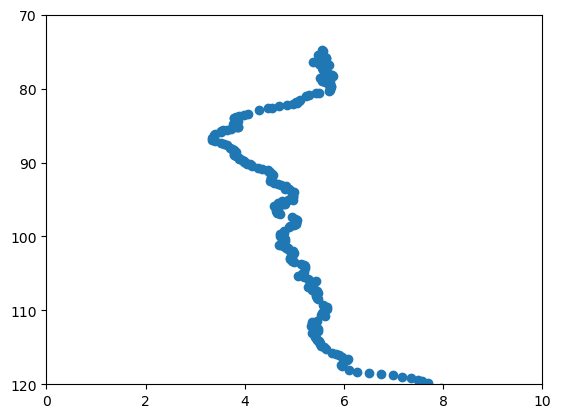

In [24]:
fig = plt.figure()
plt.scatter( qv_flash, p1 )
plt.gca().invert_yaxis()
plt.gca().set_xlim([0,10])
plt.gca().set_ylim([120,70])